# Negative covfefe
__Задание найти какие фирмы-опросники относятся более лояльно к кампании Трампу и наоборот.__ 

### Данные:
* __subgroup__ -           Подгруппа, к которой относится опрос, определяется типом опрашиваемых людей (all polls, voters, adults)
* __startdate__ -         День начала опроса
* __enddate__ -        День завершения опроса
* __pollster__ -           Фирма-опросник
* __grade__ -          Оценка Президента Трампа, соответствующая рейтингам респондентов
* __samplesize__ -        Развмер выборки
* __population__ -         Тип людей, которые были опрошены (a for adults, lv for likely voters, rv for registered voters)
* __weight__ -             Вес, который fivethirtyeightдает даёт опросу при определении рейтингов одобрения, основанных на исторической точности опроса
* __approve__ -            Доля респондентов, одобряющих президента
* __disapprove__ -         Доля респондентов, не одобряющих президента
* __adjusted_approve__ -   Доля респондентов, одобряющих президента, скорректирована с учетом систематических тенденций деятельности избирательной фирмы
* __adjusted_disapprove__ -  Доля респондентов, не одобряющих президента, скорректирована с учетом систематических тенденций деятельности избирательной фирмы 
* __multiversions__ -      True если существует несколько версий опроса, False если нет
* __tracking__ -           TRUE если опрос можно было отслеживать, FALSE если нет
* __url__ -                Ссылка на результат опроса
* __poll_id__ -            ID опроса
* __question_id__ -        ID number for the question being polled
* __createddate__ -       Дата, когда опрос был составлен
* __timestamp__ -          Дата и время когда опрос загрузили в базу данных

### Импортируем и очищаем данные, удаляем ненужные колонки.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

def clear_data(df):
    # удаляем ненужные колонки
    df = df.drop(['president', 'multiversions', 'tracking', 
                  'url', 'influence', 'modeldate',
                  'timestamp', 'grade', ], axis=1)

    return df

# импортируем и чистим данные
df = clear_data(pd.read_csv('approval_polllist.csv'))
df.head()

,subgroup,startdate,enddate,pollster,samplesize,population,weight,approve,disapprove,adjusted_approve,adjusted_disapprove,poll_id,question_id,createddate
0,All polls,1/20/2017,1/22/2017,Gallup,1500.0,a,0.245429,45.0,45.0,46.19079,43.08462,49253,77265,1/23/2017
1,All polls,1/20/2017,1/22/2017,Morning Consult,1992.0,rv,0.944206,46.0,37.0,43.65441,39.17358,49249,77261,1/23/2017
2,All polls,1/20/2017,1/24/2017,Ipsos,1632.0,a,0.224456,42.1,45.2,42.57524,44.01445,49426,77599,3/1/2017
3,All polls,1/21/2017,1/23/2017,Gallup,1500.0,a,0.226788,45.0,46.0,46.19079,44.08462,49262,77274,1/24/2017
4,All polls,1/20/2017,1/25/2017,Quinnipiac University,1190.0,rv,1.644662,36.0,44.0,37.73200,42.62336,49260,77272,1/26/2017


### Напишем функцию для отображения результатов опросов, сделанных конкретной фирмой. Это удобно сделать для визуального отображения и сравнения тенденций разных фирм-опросников в конкретный промежуток времени.

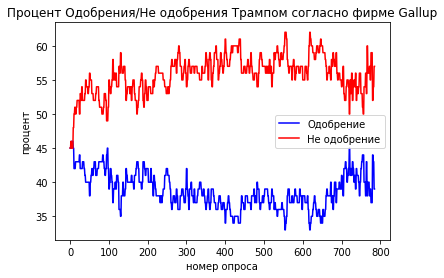

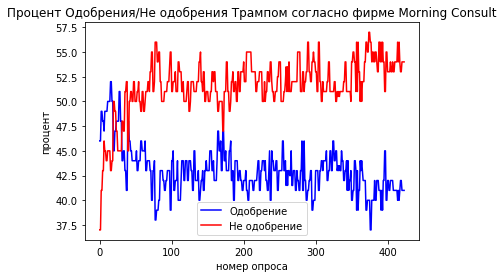

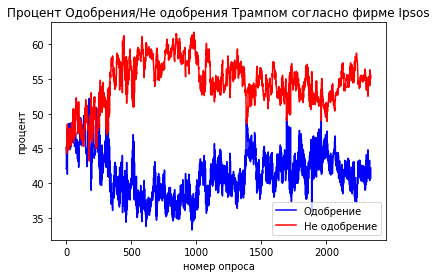

In [6]:
# получаем статистику одобрения/не одобрения по названию фирмы-опросника
def grades_distribution(df, pollster_name):
    pollster = df.loc[df['pollster'] == pollster_name]
    # get approval rates
    rates = [[item[0], item[1]] 
             for item in sorted(list(zip(
                 pollster['approve'].tolist(), pollster['disapprove'].tolist(), pollster['enddate'])), 
                     key=lambda x: datetime.strptime(x[2], '%m/%d/%Y'))]

    return pd.DataFrame.from_dict({'pollster': pd.Series([pollster_name]*len(rates)),
                                   'approval': [item[0] for item in rates], 
                                   'disapproval': [item[1] for item in rates]})

# отображаем проценты одобрения/не одобрения согласно определённой фирмы-опросника отсортированной по timeline
def show_rates_timeline(dist):
    plt.plot(dist['approval'], color='blue', label='Одобрение')
    plt.plot(dist['disapproval'], color='red', label='Не одобрение')
    plt.title('Процент Одобрения/Не одобрения Трампом согласно фирме {}'.format(dist['pollster'][0]))
    plt.xlabel('номер опроса')
    plt.ylabel('процент')
    plt.legend()
    plt.show()

# пример данных фирмы-опросника Gallup
pollster = 'Gallup'
show_rates_timeline(grades_distribution(df, pollster))
# пример данных фирмы-опросника Morning Consult
pollster = 'Morning Consult'
show_rates_timeline(grades_distribution(df, pollster))
# пример данных фирмы-опросника Ipsos
pollster = 'Ipsos'
show_rates_timeline(grades_distribution(df, pollster))

### Покажем распределение рейтингов по всем фирмам-опросникам.

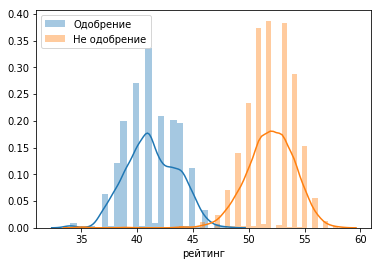

In [8]:
# распределение рейтингов
def show_rates_dist(dist):
    avl = sns.distplot(dist['approval'].values, hist=True, label='Одобрение', axlabel='рейтинг')
    disavl = sns.distplot(dist['disapproval'].values, hist=True, label='Не одобрение')
    plt.legend()
    plt.show()

pollster = 'YouGov'
show_rates_dist(grades_distribution(df, pollster))

### Получим названия всех уникальных фирм-опросников для дальнейшей предобработки данных.

In [9]:
# получаем все уникальные названия фирм-опросников
all_pollsters = pd.Series(list(set(df['pollster'])))
all_pollsters.head()

0                 Greenberg Quinlan Rosner
1    Garin-Hart-Yang/Global Strategy Group
2                           Tarrance Group
3                          Morning Consult
4                    USC Dornsife/LA Times
dtype: object

# Регрессия
## __Отклик:__
* __net approval rating:__ % одобрения Трампом минус % не оборения Трампом.

## __Регрессоры:__
* __Survey population:__ Adults, Likely voters, Registered voters.
* __Days since the inauguration:__ Считается как разница в днях между днём окончания опроса и 20.01.2017.
* __Poll field time:__ Считается как разница в днях между концом и началом опроса.
* __No opinion percentage:__ Считается как разница между 100% и суммой одобрения и не одобрения Трампом. Получается процент людей, которые были не уверены или не имели мнения на счёт Трампа в опросе. 
* __Pollster:__ Фирма-опросник, которая проводила опрос.
* __Subgroup:__ Тип людей, над которыми проводили опрос (all polls, voters, adults)

### Производим предобработку данных перед регрессией. Считаем регрессоры и загоняем их в удобный формат для последующего подбора прямой.

In [10]:
# предобработка данных
def preprocess(df):
    data = pd.DataFrame()
    # считаем отклик
    data['net_approval'] = df['approve'] - df['disapprove']
    # считаем популяцию
    popul_cvr = {'a': 0, 'rv': 1, 'lv': 2}
    data['population'] = df.apply(lambda x: popul_cvr[x['population']], axis=1)
    # считаем сколько дней прошло с инагурации
    data['days_inaug'] = df.apply(lambda x: 
                                  (datetime.strptime(x['enddate'], '%m/%d/%Y') - 
                                  datetime.strptime('1/20/2017', '%m/%d/%Y')).days, axis=1)
    # считаем продолжительность опроса
    data['poll_time'] = df.apply(lambda x: (datetime.strptime(x['enddate'], '%m/%d/%Y') -
                                            datetime.strptime(x['startdate'], '%m/%d/%Y')).days, axis=1)
    # считаем количество людей без мнения на счёт Трампа
    data['no_opinion'] = df.apply(lambda x: 100 - (x['approve'] + x['disapprove']), axis=1)
    # Добавляем названия фирм-опросников
    pollster_cvr = {pollster: i for i, pollster in enumerate(all_pollsters)}
    data['pollster'] = df.apply(lambda x: pollster_cvr[x['pollster']], axis=1)
    # Добавляем тип людей, которые участвовали в опросе
    subgroup_cvr = {'Adults': 0, 'All polls': 1, 'Voters': 2}
    data['subgroup'] = df.apply(lambda x: subgroup_cvr[x['subgroup']], axis=1)
    
    return data

data = preprocess(df)
data.head()

,net_approval,population,days_inaug,poll_time,no_opinion,pollster,subgroup
0,0.0,0,2,2,10.0,29,1
1,9.0,1,2,2,17.0,3,1
2,-3.1,0,4,4,12.7,5,1
3,-1.0,0,3,2,9.0,29,1
4,-8.0,1,5,5,20.0,7,1


### Считаем коэффициенты регрессии, строим прямую и показываем данные по регрессии. 

In [12]:
import statsmodels.api as sm

X, y = data.loc[:, 'population':'subgroup'].values, data['net_approval'].values
# добавляем intercept
X_train = sm.add_constant(X)
# считаем коэффициенты регрессии линейной модели
reg = sm.OLS(y, X_train).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     398.3
Date:                Wed, 19 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:33:30   Log-Likelihood:                -24637.
No. Observations:                7738   AIC:                         4.929e+04
Df Residuals:                    7731   BIC:                         4.934e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.2081      0.298    -57.811      0.000     -17.792     -16.625
x1             5.0979      0.148     34.491      0.000       4.808       5.388
x2             0.0040      0.000     13.674      0.000       0.003       0.005
x3            -0.1477      0.032     -4.611      0.000      -0.210      -0.085
x4             0.4167      0.029     14.195      0.000       0.359       0.474
x5            -0.0051      0.005     -1.111      0.267      -0.014       0.004
x6            -0.6494      0.122     -5.307      0.000      -0.889      -0.410
==============================================================================
Omnibus:                      150.946   Durbin-Watson:                   1.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.712
Skew:                           0.040   Prob(JB):                     1.02e-69
Kurtosis:                       3.989   Cond. No.                     2.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Посмотрим p-значение для каждого регрессора.

In [13]:
# покажем p-значение для каждого регрессора
for i in range(X.shape[1] + 1):
    print('x{} p-value: {}'.format(i, reg.pvalues[i]))

x0 p-value: 0.0
x1 p-value: 1.3076846793254796e-242
x2 p-value: 4.441404247385704e-42
x3 p-value: 4.062162470713125e-06
x4 p-value: 3.6310100998872914e-45
x5 p-value: 0.2666953357881492
x6 p-value: 1.1447384440173357e-07


#### Все p-значения меньше 0.05, потому переменные, которые мы ввели являются статистически значимыми.

# Считаем "House effect" и определяем какие фирмы-опросники относятся к Трампу более лояльно и наоборот.

### Берём данные с нашей регрессии и рисуем график "лояльности" (чем более "сниний" boxplot, тем лояльней компания-опросник относится к Трампу). По нашим данным, Heart+Mind Strategies является самой лояльной к Трампу компанией в то время как University of Maryland/Washington Post наоборот самая нелояльная компания.

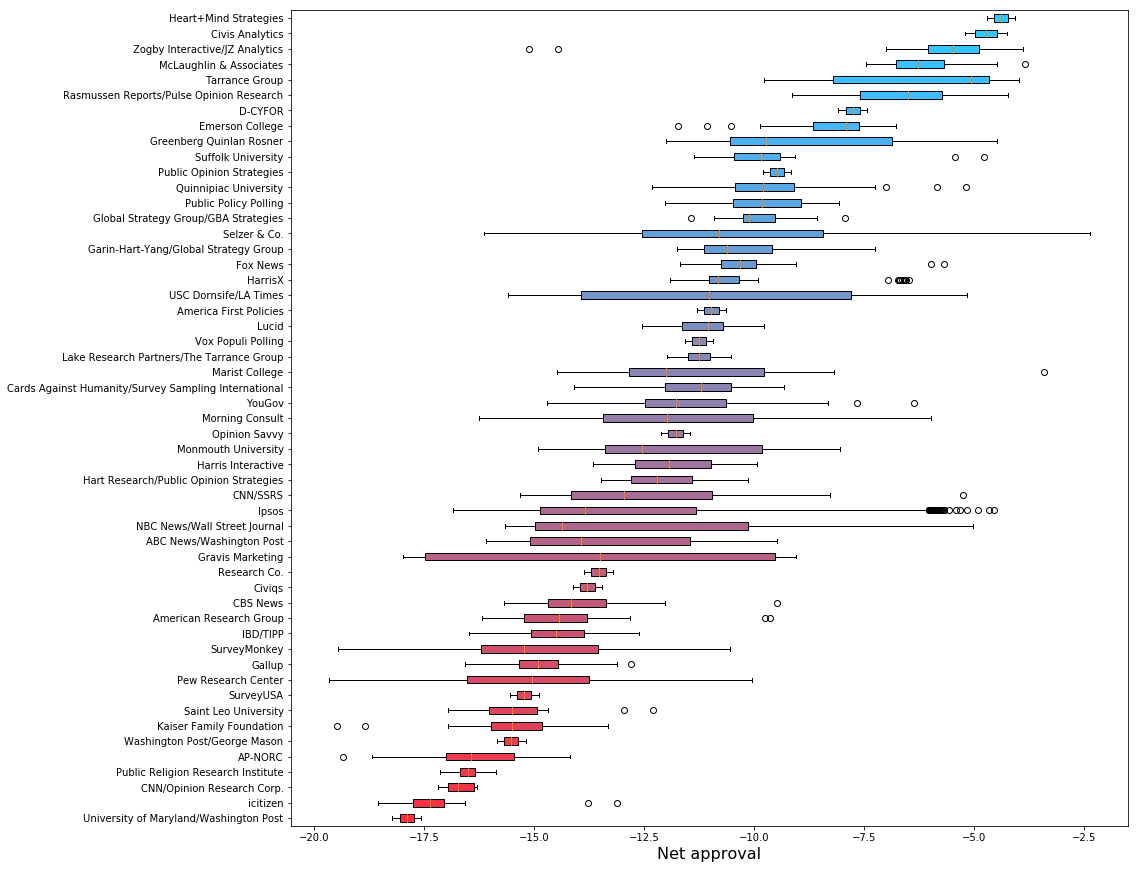

In [14]:
pollster_cvr_inv = {i: pollster for i, pollster in enumerate(all_pollsters)}

boxplot_data = {}
# получаем данные по каждой фирме с нашей регрессии
for i in range(len(all_pollsters)):
    pollster_data = data.loc[data['pollster'] == i].loc[:, 'population':'subgroup'].values
    pollster_data = np.insert(pollster_data, 0, [1]*len(pollster_data), axis=1)
    pred = reg.predict(pollster_data)
    boxplot_data[pollster_cvr_inv[i]] = pred

# отображаем boxplot график
plt.rcParams["figure.figsize"] = (15,15)
boxplot_data = np.array(sorted(boxplot_data.items(), key=lambda x: np.mean(np.array(x[1]))))
labels, box_data = boxplot_data[:, 0], boxplot_data[:, 1]

bp = plt.boxplot(box_data, vert=False, labels=labels, patch_artist=True)
start_color, end_color = [[255, 44, 61], [25, 180, 254]]
diff = [round((y - x)/len(labels)) for x, y in zip(start_color, end_color)]

for box in bp['boxes']:
    # меянм цвет
    box.set(color='black', linewidth=1)
    # добавляем градиент
    start_color = [(x + y) for x, y in zip(start_color, diff)]
    box.set(facecolor=[item/255 if item/255 <= 1 and item/255 >= 0 else 1 for item in start_color])

plt.xlabel('Net approval', fontsize=16)

plt.show()

### Покажем результаты посредством гистограммы, где по оси x будут расположены фирмы-опросники, а по оси y  "House effect".

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go

# получаем данные по каждой фирме из нашей регрессии
barchart_data = {}
for i in range(len(all_pollsters)):
    pollster_data = data.loc[data['pollster'] == i].loc[:, 'population':'subgroup'].values
    pollster_data = np.insert(pollster_data, 0, [1]*len(pollster_data), axis=1)
    pred = reg.predict(pollster_data)
    barchart_data[pollster_cvr_inv[i]] = pred

mean_value = np.mean(np.array([poll for poll_data in barchart_data.values() for poll in poll_data]))
# отображаем barchart
plt.rcParams["figure.figsize"] = (15,15)
barchart_data = np.array(sorted(barchart_data.items(), key=lambda x: np.mean(np.array(x[1]))))
# корректируем данные по среднему значению
barchart_data = np.array([[key, np.mean(value) - mean_value] for key, value in barchart_data])
labels, barchart_data = barchart_data[:, 0], barchart_data[:, 1]

plot_data = [
    go.Bar(
        x = labels,
        y = barchart_data,
        base = 0,
        marker=dict(
            color=list(range(len(labels))),
            colorbar=dict(
                title='Effect',
                tickmode = 'array',
                tickvals = []
            ),
            colorscale='Viridis'
        ),
        name = 'effect'
    )
]
layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    title=go.layout.Title(
        text='House effect of Trump approval rating'
    ),
    xaxis=go.layout.XAxis(
        tickmode='array',
        automargin=True,
        titlefont=dict(size=30),
    ),
    paper_bgcolor='#7f7f7f',
    plot_bgcolor='#c7c7c7'
)

fig = go.Figure(data=plot_data)
py.iplot(fig, filename='base-bar', layout=layout)


/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# График выше описывает "House effect" 53-х разных фирм-опросников, где net rating был использован как отклик в регрессии. Желтый цвет описыват лояльное отношение к Трампу в то время как фиолетовый наоборот. По оси y показан сила эффекта смещённая по его среднему значению. 